In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# Download 3 years of data
stock = yf.Ticker("^NSEI") 
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=3)
data = stock.history(start=start_date, end=end_date)

print("Data Overview:")
print(f"Date Range: {data.index.min()} to {data.index.max()}")
print(f"Total Trading Days: {len(data)}")
print("\nFirst few rows of data:")
data.head()

Data Overview:
Date Range: 2022-03-08 00:00:00+05:30 to 2025-03-07 00:00:00+05:30
Total Trading Days: 742

First few rows of data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-08 00:00:00+05:30,15747.750000,16028.750000,15671.450195,16013.450195,543600,0.0,0.0
2022-03-09 00:00:00+05:30,16078.000000,16418.050781,15990.000000,16345.349609,462200,0.0,0.0
2022-03-10 00:00:00+05:30,16757.099609,16757.300781,16447.900391,16594.900391,486400,0.0,0.0
2022-03-11 00:00:00+05:30,16528.800781,16694.400391,16470.900391,16630.449219,343700,0.0,0.0
2022-03-14 00:00:00+05:30,16633.699219,16887.949219,16606.500000,16871.300781,314700,0.0,0.0


In [ ]:
def preprocess_data(df):
    # Handle missing values
    df = df.ffill().bfill()    
    # Handle outliers using IQR method
    def remove_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series >= lower_bound) & (series <= upper_bound)]
    
    # Remove price and volume outliers
    df['Close'] = remove_outliers(df['Close'])
    df['Volume'] = remove_outliers(df['Volume'])
    
    # Calculate technical indicators
    # 1. Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # 2. RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 3. MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Calculate returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    return df

# Apply preprocessing
data = preprocess_data(data)

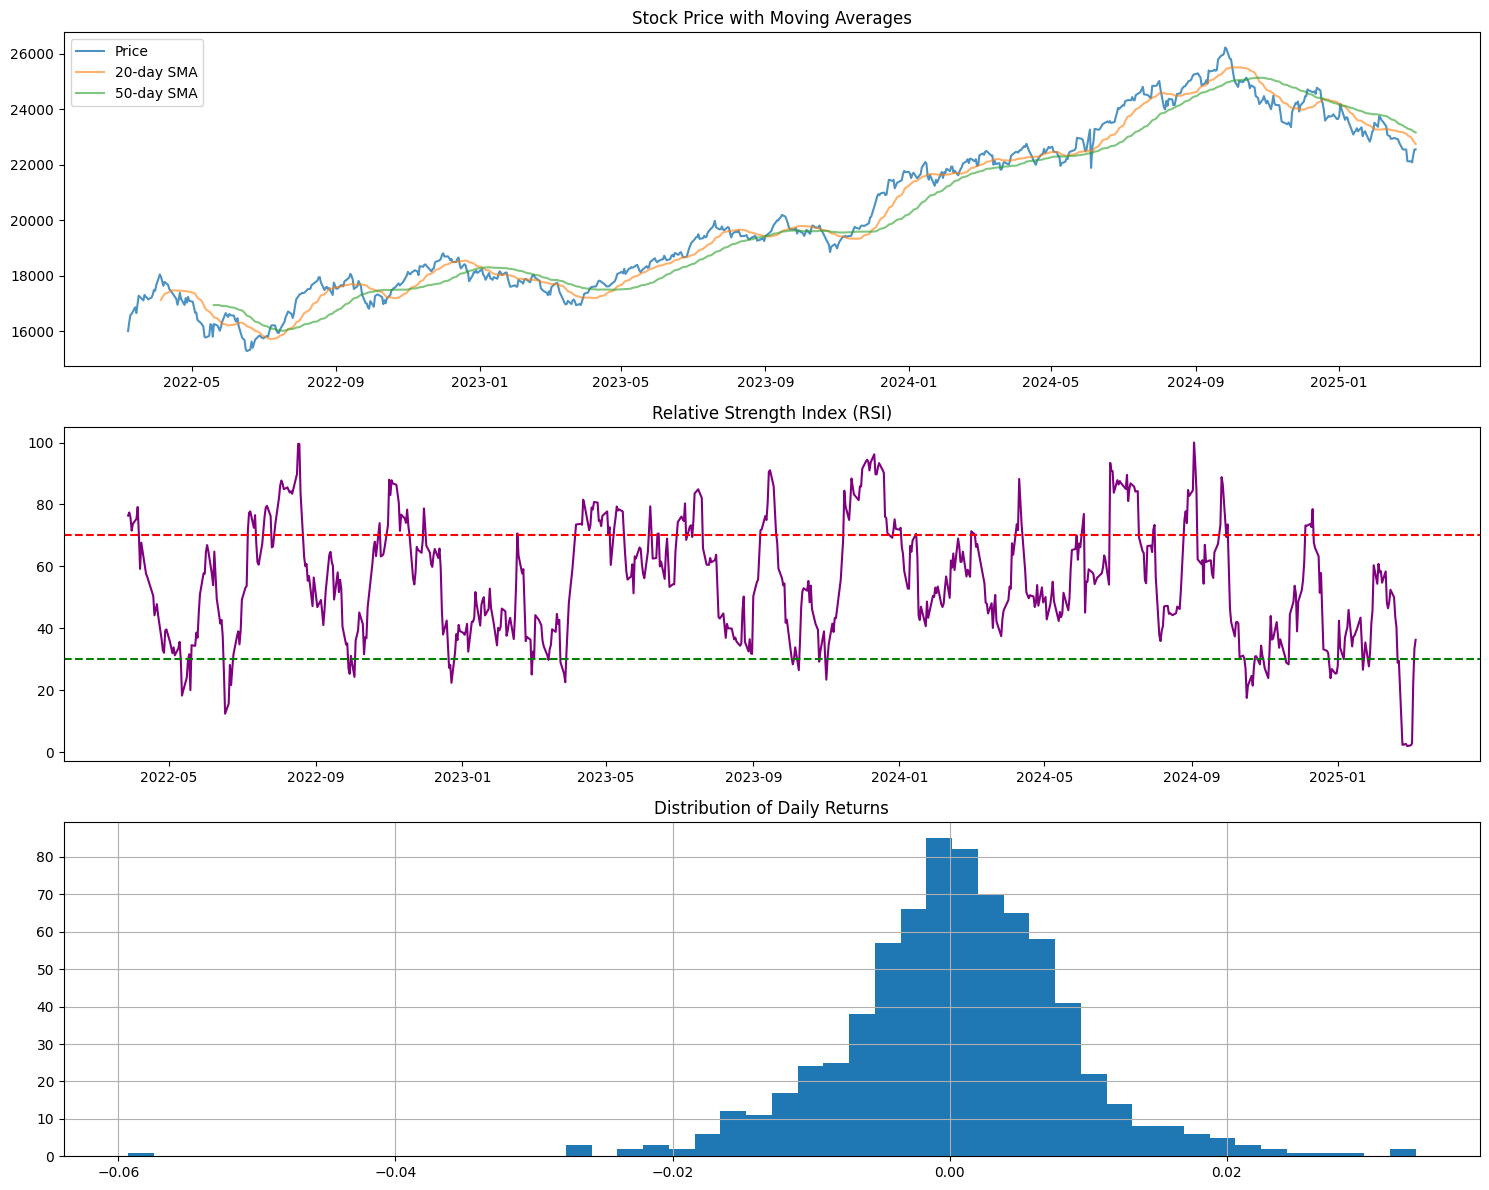

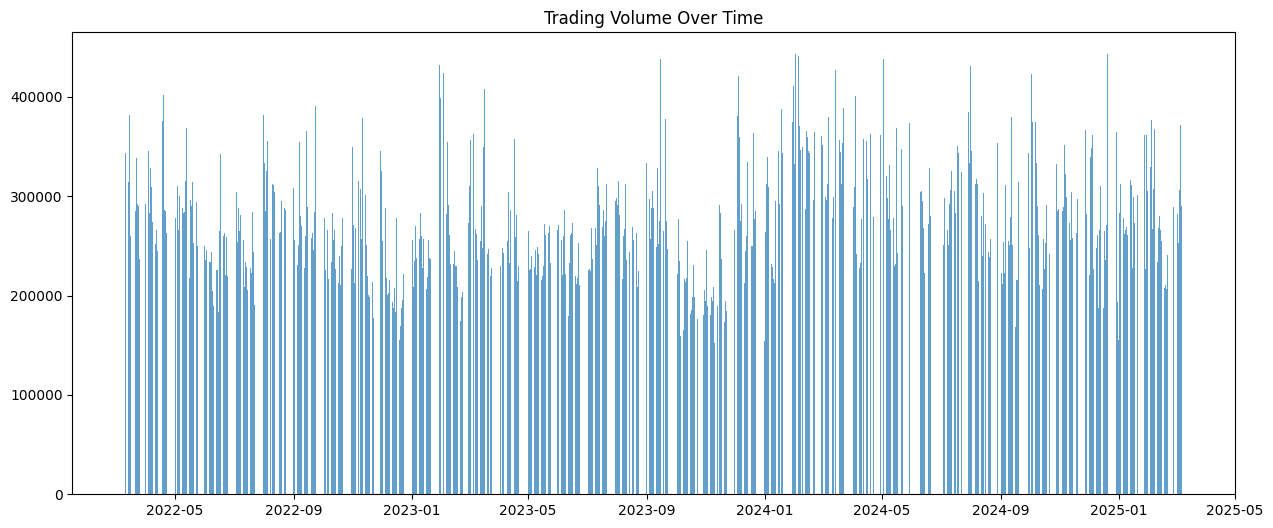

In [32]:
plt.figure(figsize=(15, 12))

# 1. Price and Technical Indicators
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], label='Price', alpha=0.8)
plt.plot(data.index, data['SMA_20'], label='20-day SMA', alpha=0.6)
plt.plot(data.index, data['SMA_50'], label='50-day SMA', alpha=0.6)
plt.title('Stock Price with Moving Averages')
plt.legend()

# 2. RSI
plt.subplot(3, 1, 2)
plt.plot(data.index, data['RSI'], color='purple')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.title('Relative Strength Index (RSI)')

# 3. Returns Distribution
plt.subplot(3, 1, 3)
data['Daily_Return'].hist(bins=50)
plt.title('Distribution of Daily Returns')

plt.tight_layout()
plt.show()

# Volume Analysis
plt.figure(figsize=(15, 6))
plt.bar(data.index, data['Volume'], alpha=0.7)
plt.title('Trading Volume Over Time')
plt.show()



In [33]:
# Print summary statistics
print("\nSummary Statistics:")
print(data[['Close', 'Daily_Return', 'Volume', 'RSI']].describe())

# Check for any remaining missing values
print("\nMissing Values:")
print(data.isnull().sum())


Summary Statistics:
              Close  Daily_Return         Volume         RSI
count    742.000000    741.000000     693.000000  729.000000
mean   20227.284859      0.000497  274172.294372   55.140533
std     2887.089987      0.008362   59370.408104   18.787562
min    15293.500000     -0.059294  145900.000000    2.022397
25%    17755.412598     -0.004039  230200.000000   40.729892
50%    19527.650391      0.000644  265200.000000   54.513459
75%    22741.525391      0.005368  308800.000000   69.514475
max    26216.050781      0.033624  442800.000000  100.000000

Missing Values:
Open             0
High             0
Low              0
Close            0
Volume          49
Dividends        0
Stock Splits     0
SMA_20          19
SMA_50          49
RSI             13
MACD             0
Signal_Line      0
Daily_Return     1
dtype: int64


In [34]:
def prepare_for_ml(data):
    """
    Prepare features and target for machine learning
    """
    # Create target (1 if price goes up tomorrow, 0 if down)
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    
    # Select features
    features = [
        'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 
        'Daily_Return'
    ]
    
    # Drop any remaining NaN values
    data = data.dropna()
    
    # Separate features and target
    X = data[features]
    y = data['Target']
    
    return X, y

In [63]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def train_evaluate_models(X, y):
    """
    Train and evaluate multiple models
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred)
        }
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        results[name]['CV_Score'] = cv_scores.mean()
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Plot ROC curve
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8   , 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
        
    return results, models




Training Logistic Regression...


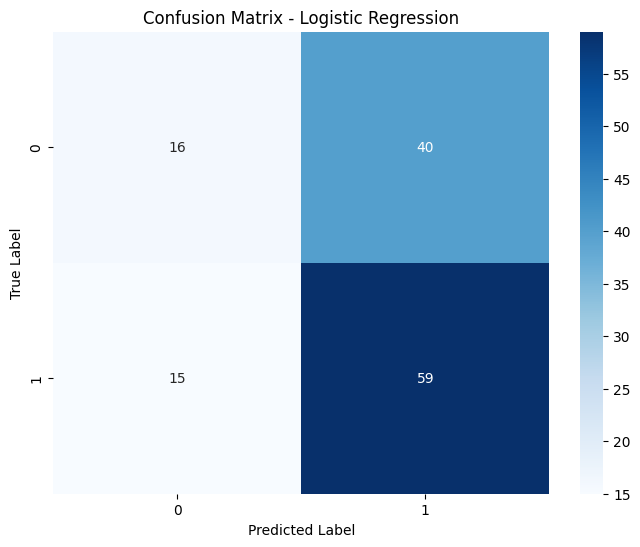

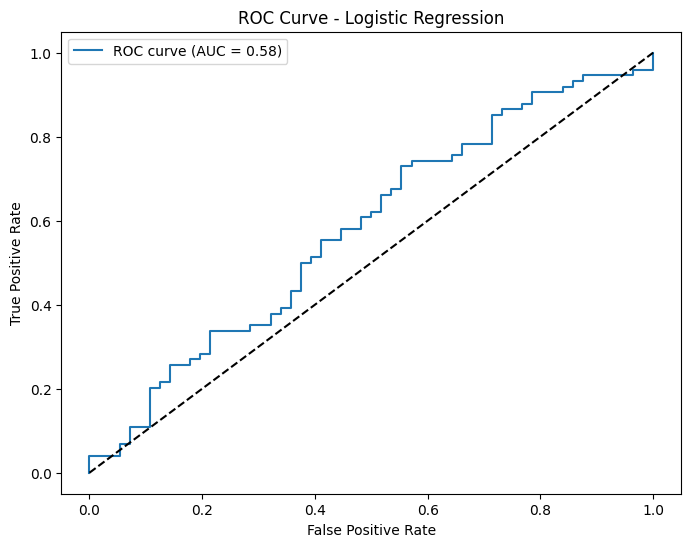


Training Random Forest...


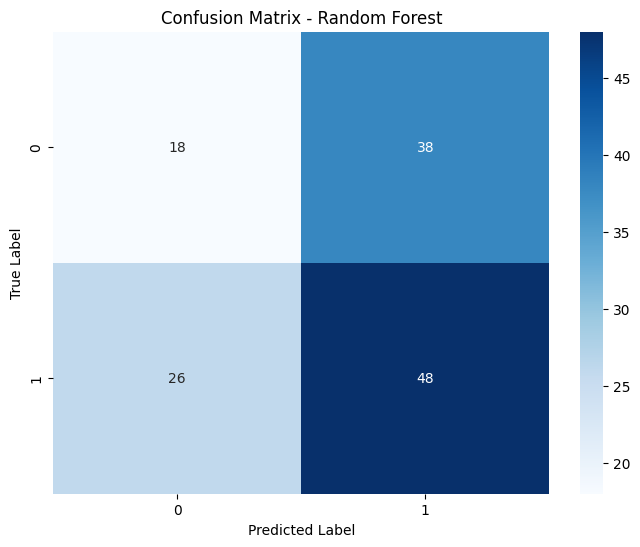

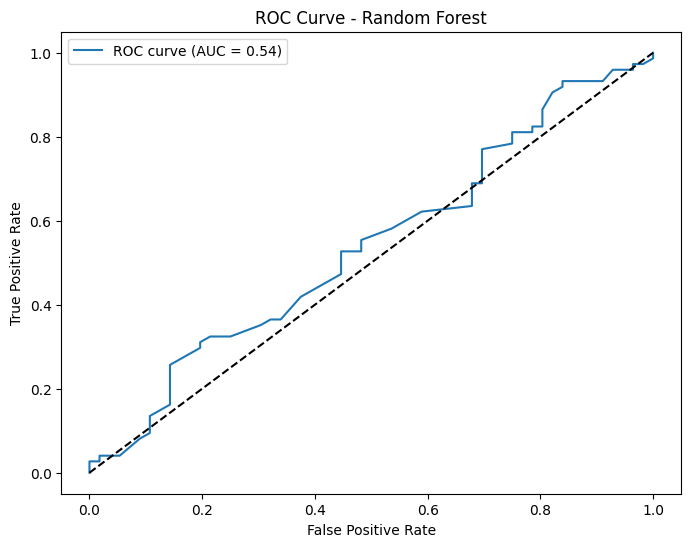


Training XGBoost...


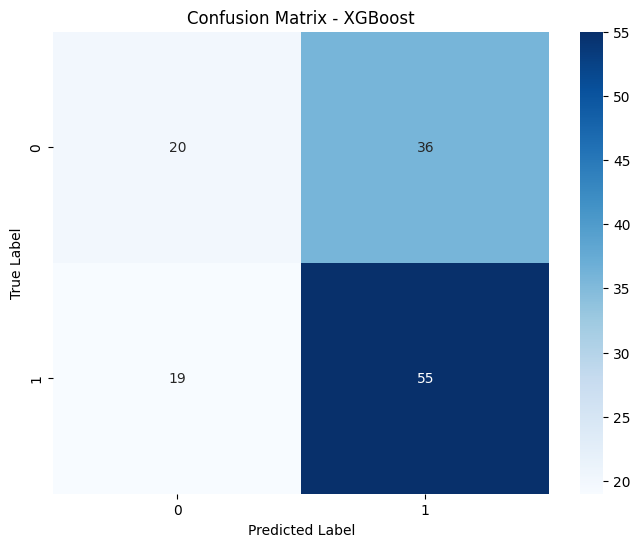

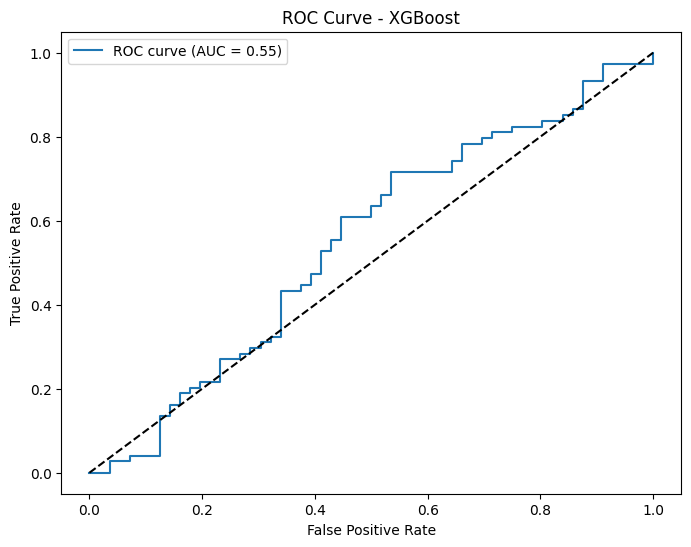


Model Performance Summary:
           Logistic Regression  Random Forest  XGBoost
Accuracy                 0.577          0.508    0.577
Precision                0.596          0.558    0.604
Recall                   0.797          0.649    0.743
F1 Score                 0.682          0.600    0.667
CV_Score                 0.565          0.551    0.553


In [37]:
# Run the analysis
X, y = prepare_for_ml(data)
results, models = train_evaluate_models(X, y)

# Print summary results
print("\nModel Performance Summary:")
results_df = pd.DataFrame(results).round(3)
print(results_df)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import numpy as np

In [39]:
def improve_models(X, y):
    """
    Improve model performance using hyperparameter tuning and ensemble methods
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 1. Hyperparameter Tuning
    
    # Random Forest parameters (reduced parameter grid for faster execution)
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }
    
    # XGBoost parameters (reduced parameter grid for faster execution)
    xgb_params = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200]
    }
    
    try:
        # Perform Grid Search
        print("Training Random Forest with Grid Search...")
        rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                             rf_params, cv=5, scoring='f1')
        rf_grid.fit(X_train_scaled, y_train)
        print("\nBest Random Forest parameters:", rf_grid.best_params_)
        
        print("\nTraining XGBoost with Grid Search...")
        xgb_grid = GridSearchCV(XGBClassifier(random_state=42), 
                              xgb_params, cv=5, scoring='f1')
        xgb_grid.fit(X_train_scaled, y_train)
        print("\nBest XGBoost parameters:", xgb_grid.best_params_)
        
        # 2. Create Ensemble Model
        estimators = [
            ('lr', LogisticRegression(random_state=42)),
            ('rf', rf_grid.best_estimator_),
            ('xgb', xgb_grid.best_estimator_)
        ]
        
        ensemble = VotingClassifier(estimators=estimators, voting='soft')
        ensemble.fit(X_train_scaled, y_train)
        
        # 3. Evaluate all models
        models = {
            'Tuned Random Forest': rf_grid.best_estimator_,
            'Tuned XGBoost': xgb_grid.best_estimator_,
            'Ensemble': ensemble
        }
        
        results = {}
        
        for name, model in models.items():
            y_pred = model.predict(X_test_scaled)
            
            results[name] = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1 Score': f1_score(y_test, y_pred)
            }
            
            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
            # Print feature importance for RF and XGB
            if hasattr(model, 'feature_importances_'):
                importances = pd.DataFrame({
                    'feature': X.columns,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                print(f"\nFeature Importance for {name}:")
                print(importances)
        
        return results
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


In [40]:
def add_features(X):
    # Volatility
    returns = np.log(X['Close']/X['Close'].shift(1))
    X['Volatility'] = returns.rolling(window=20).std() * np.sqrt(252)
    
    # Price momentum
    X['Momentum'] = X['Close'] - X['Close'].shift(10)
    
    # RSI changes
    X['RSI_Change'] = X['RSI'] - X['RSI'].shift(1)
    
    # MACD histogram
    X['MACD_Hist'] = X['MACD'] - X['Signal_Line']
    
    # Volume trend
    X['Volume_Trend'] = X['Volume'].rolling(window=5).mean() / X['Volume'].rolling(window=20).mean()
    
    return X


In [41]:
def prepare_for_ml(data):
    """
    Prepare features and target for machine learning
    """
    # Create target (1 if price goes up tomorrow, 0 if down)
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    
    # Select features
    features = [
        'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 
        'Daily_Return'
    ]
    
    # Drop any remaining NaN values
    data = data.dropna()
    
    # Separate features and target
    X = data[features]
    y = data['Target']
    
    return X, y

Training Random Forest with Grid Search...

Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Training XGBoost with Grid Search...

Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


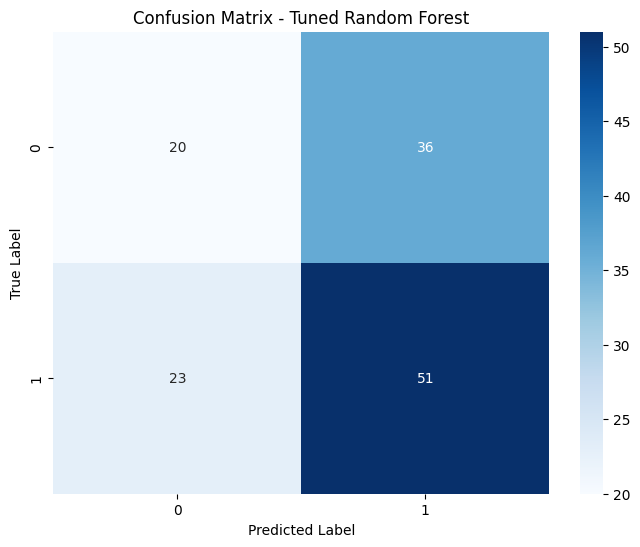


Feature Importance for Tuned Random Forest:
        feature  importance
5  Daily_Return    0.192492
4   Signal_Line    0.170921
2           RSI    0.167689
3          MACD    0.164052
1        SMA_50    0.159997
0        SMA_20    0.144850


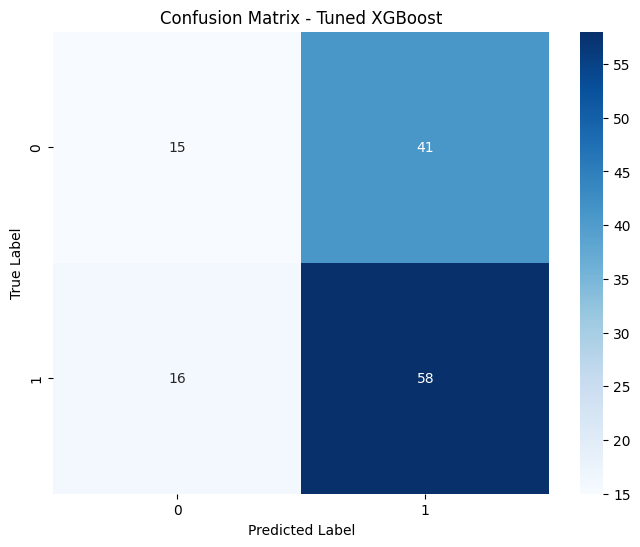


Feature Importance for Tuned XGBoost:
        feature  importance
5  Daily_Return    0.209184
4   Signal_Line    0.197318
2           RSI    0.179031
3          MACD    0.168100
0        SMA_20    0.154548
1        SMA_50    0.091818


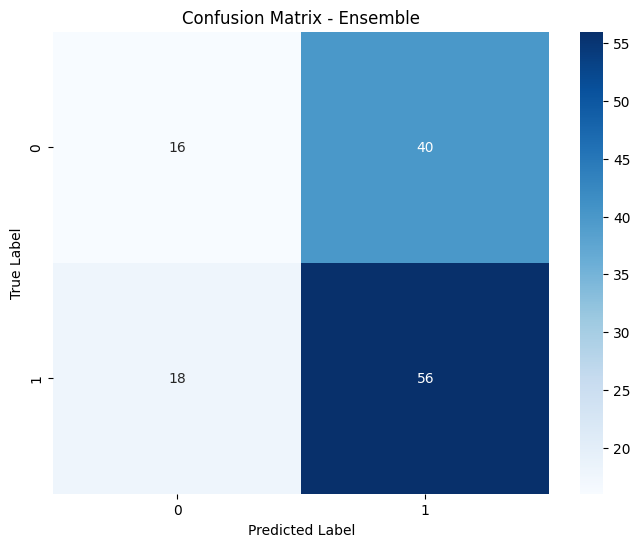


Improved Model Performance Summary:
           Tuned Random Forest  Tuned XGBoost  Ensemble
Accuracy                 0.546          0.562     0.554
Precision                0.586          0.586     0.583
Recall                   0.689          0.784     0.757
F1 Score                 0.634          0.671     0.659


In [42]:
X, y = prepare_for_ml(data)
improved_results = improve_models(X, y)

if improved_results is not None:
    # Print summary results
    print("\nImproved Model Performance Summary:")
    improved_results_df = pd.DataFrame(improved_results).round(3)
    print(improved_results_df)
    

Training Random Forest with Grid Search...

Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Training XGBoost with Grid Search...

Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


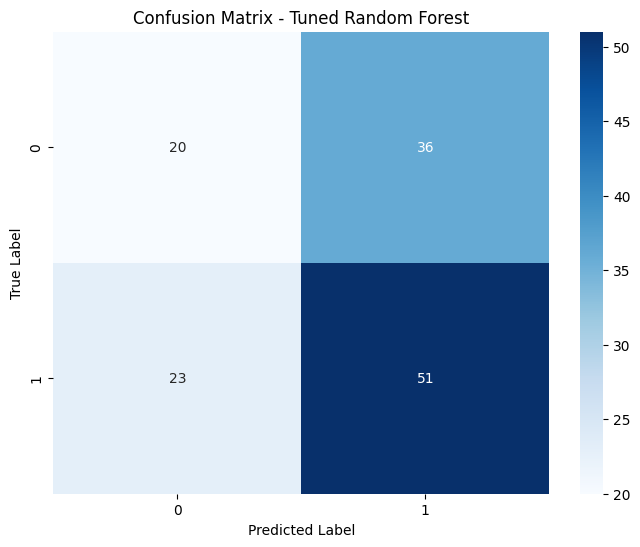


Feature Importance for Tuned Random Forest:
        feature  importance
5  Daily_Return    0.192492
4   Signal_Line    0.170921
2           RSI    0.167689
3          MACD    0.164052
1        SMA_50    0.159997
0        SMA_20    0.144850


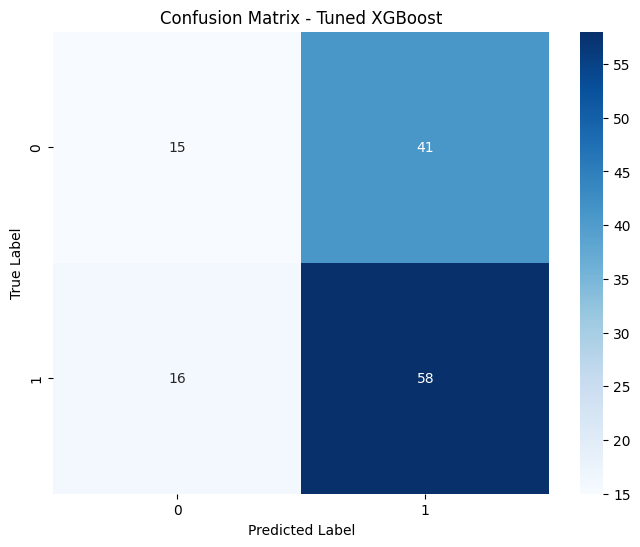


Feature Importance for Tuned XGBoost:
        feature  importance
5  Daily_Return    0.209184
4   Signal_Line    0.197318
2           RSI    0.179031
3          MACD    0.168100
0        SMA_20    0.154548
1        SMA_50    0.091818


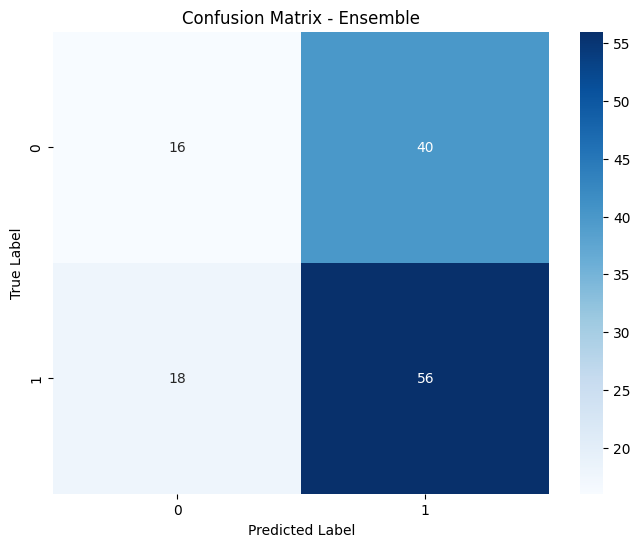


Model Performance Comparison:

Original Models:
           Logistic Regression  Random Forest  XGBoost
Accuracy                 0.577          0.508    0.577
Precision                0.596          0.558    0.604
Recall                   0.797          0.649    0.743
F1 Score                 0.682          0.600    0.667
CV_Score                 0.565          0.551    0.553

Improved Models:
           Tuned Random Forest  Tuned XGBoost  Ensemble
Accuracy                 0.546          0.562     0.554
Precision                0.586          0.586     0.583
Recall                   0.689          0.784     0.757
F1 Score                 0.634          0.671     0.659

Improvements in percentage points:
Accuracy: -1.54%
Precision: -1.82%
Recall: -1.35%
F1 Score: -1.16%


In [43]:
# First, let's store our original results
original_results = results  # Save the results from our first model run

# Now run the improved models
improved_results = improve_models(X, y)

# Compare results side by side
print("\nModel Performance Comparison:")
print("\nOriginal Models:")
original_df = pd.DataFrame(original_results).round(3)
print(original_df)

print("\nImproved Models:")
improved_df = pd.DataFrame(improved_results).round(3)
print(improved_df)

# Calculate improvements
def calculate_improvement(original, improved):
    improvements = {}
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
        # Get best score for each metric from original and improved models
        original_best = max(original[model][metric] for model in original)
        improved_best = max(improved[model][metric] for model in improved)
        
        improvement = (improved_best - original_best) * 100
        improvements[metric] = improvement
    
    return improvements

improvements = calculate_improvement(original_results, improved_results)

print("\nImprovements in percentage points:")
for metric, improvement in improvements.items():
    print(f"{metric}: {improvement:.2f}%")

In [44]:
def optimize_models(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 1. Simpler parameter grids
    rf_params = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [5, 10]
    }
    
    xgb_params = {
        'max_depth': [3, 4],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [50, 100],
        'subsample': [0.8]
    }
    
    # 2. Add class weights to handle imbalance
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        rf_params, cv=5, scoring='f1'
    )
    
    xgb_grid = GridSearchCV(
        XGBClassifier(random_state=42, scale_pos_weight=1),
        xgb_params, cv=5, scoring='f1'
    )
    
    # Train models
    print("Training Random Forest...")
    rf_grid.fit(X_train_scaled, y_train)
    print("Best RF parameters:", rf_grid.best_params_)
    
    print("\nTraining XGBoost...")
    xgb_grid.fit(X_train_scaled, y_train)
    print("Best XGB parameters:", xgb_grid.best_params_)
    
    # 3. Create weighted ensemble
    models = {
        'RF': rf_grid.best_estimator_,
        'XGB': xgb_grid.best_estimator_,
        'LR': LogisticRegression(class_weight='balanced', random_state=42)
    }
    
    # Train individual models and get their validation scores
    val_scores = {}
    for name, model in models.items():
        if name == 'LR':
            model.fit(X_train_scaled, y_train)
        val_scores[name] = cross_val_score(model, X_train_scaled, y_train, cv=5).mean()
    
    # Create weighted predictions
    results = {}
    final_predictions = np.zeros(len(y_test))
    total_weight = 0
    
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        weight = val_scores[name]
        final_predictions += y_pred * weight
        total_weight += weight
        
        # Store individual model results
        results[f'Weighted_{name}'] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'Weight': weight
        }
    
    # Get final ensemble predictions
    final_predictions = (final_predictions / total_weight > 0.5).astype(int)
    
    # Add ensemble results
    results['Weighted_Ensemble'] = {
        'Accuracy': accuracy_score(y_test, final_predictions),
        'Precision': precision_score(y_test, final_predictions),
        'Recall': recall_score(y_test, final_predictions),
        'F1 Score': f1_score(y_test, final_predictions)
    }
    
    return results



In [45]:
# Run optimized models
optimized_results = optimize_models(X, y)

# Print results
print("\nOptimized Model Performance:")
optimized_df = pd.DataFrame(optimized_results).round(3)
print(optimized_df)



Training Random Forest...
Best RF parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}

Training XGBoost...
Best XGB parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

Optimized Model Performance:
           Weighted_RF  Weighted_XGB  Weighted_LR  Weighted_Ensemble
Accuracy         0.577         0.523        0.554              0.577
Precision        0.614         0.565        0.614              0.612
Recall           0.689         0.703        0.581              0.703
F1 Score         0.650         0.627        0.597              0.654
Weight           0.559         0.559        0.540                NaN


In [46]:
# Feature importance analysis
def analyze_features(X, y):
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(X, y)
    
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance)
    
    return importance

feature_importance = analyze_features(X, y)


Feature Importance:
        Feature  Importance
5  Daily_Return    0.184449
2           RSI    0.167345
1        SMA_50    0.165257
4   Signal_Line    0.164089
0        SMA_20    0.160653
3          MACD    0.158208


In [47]:
def improve_model_advanced(X, y):
    # 1. Feature Engineering
    def add_advanced_features(X):
        X = X.copy()
        
        # Volatility
        X['Volatility'] = X['Daily_Return'].rolling(window=20).std()
        
        # RSI Changes
        X['RSI_Change'] = X['RSI'].diff()
        X['RSI_MA'] = X['RSI'].rolling(window=10).mean()
        
        # MACD Features
        X['MACD_Change'] = X['MACD'].diff()
        X['MACD_Hist'] = X['MACD'] - X['Signal_Line']
        
        # Moving Average Crossovers
        X['MA_Cross'] = (X['SMA_20'] > X['SMA_50']).astype(int)
        
        return X
    
    # 2. Add new features
    X_enhanced = add_advanced_features(X)
    X_enhanced = X_enhanced.dropna()
    y = y[X_enhanced.index]  # Align target with new features
    
    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)
    
    # 4. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 5. Handle class imbalance
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    # 6. Enhanced parameter grids
    rf_params = {
        'n_estimators': [200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', 'balanced_subsample']
    }
    
    xgb_params = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05],
        'n_estimators': [200, 300],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'min_child_weight': [1, 3]
    }
    
    # 7. Train models with cross-validation
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        rf_params,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    
    xgb_grid = GridSearchCV(
        XGBClassifier(random_state=42),
        xgb_params,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    
    print("Training Enhanced Random Forest...")
    rf_grid.fit(X_train_balanced, y_train_balanced)
    print("Best RF parameters:", rf_grid.best_params_)
    
    print("\nTraining Enhanced XGBoost...")
    xgb_grid.fit(X_train_balanced, y_train_balanced)
    print("Best XGB parameters:", xgb_grid.best_params_)
    
    # 8. Create stacked model
    from sklearn.ensemble import StackingClassifier
    
    estimators = [
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_)
    ]
    
    stacked_model = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        cv=5
    )
    
    stacked_model.fit(X_train_balanced, y_train_balanced)
    
    # 9. Evaluate all models
    models = {
        'Enhanced_RF': rf_grid.best_estimator_,
        'Enhanced_XGB': xgb_grid.best_estimator_,
        'Stacked_Model': stacked_model
    }
    
    results = {}
    
    for name, model in models.items():
        # Get predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate metrics
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC_AUC': roc_auc_score(y_test, y_pred_proba)
        }
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {results[name]["ROC_AUC"]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
    
    return results, X_enhanced.columns



Training Enhanced Random Forest...
Best RF parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}

Training Enhanced XGBoost...
Best XGB parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


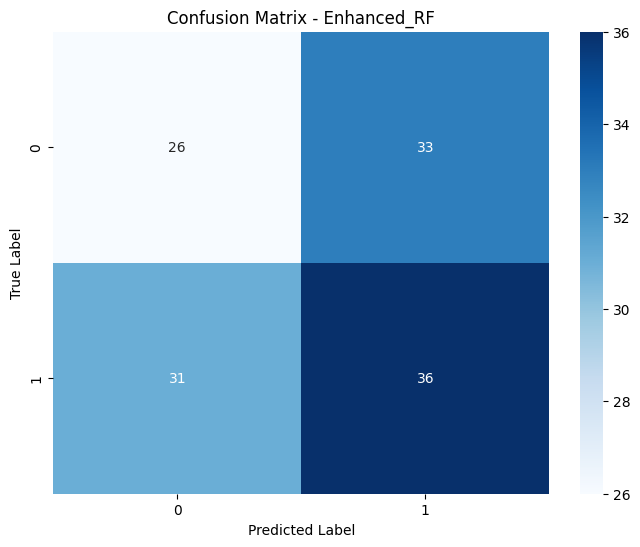

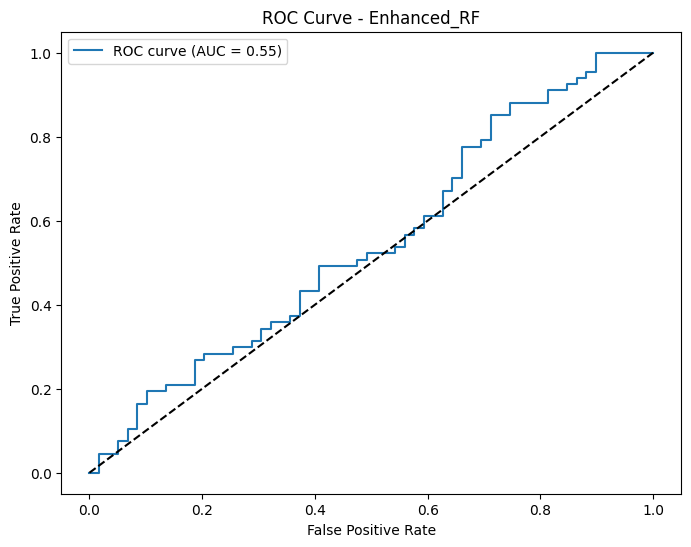

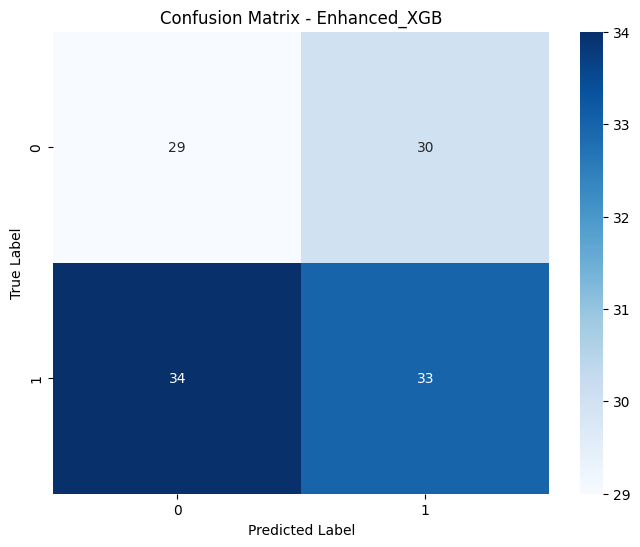

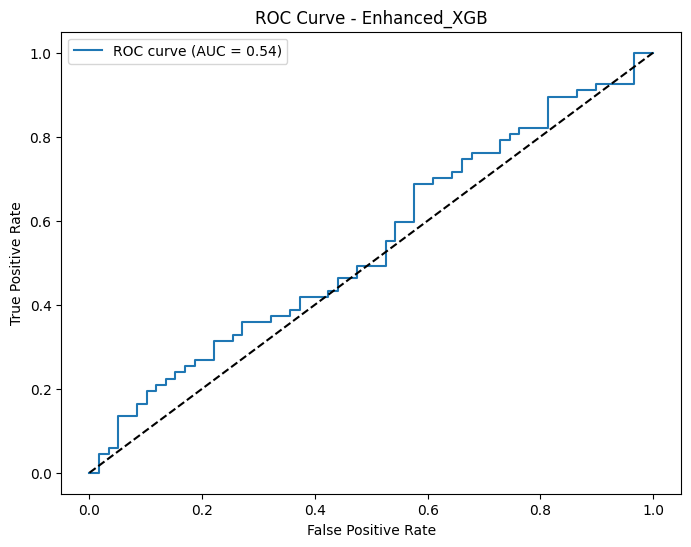

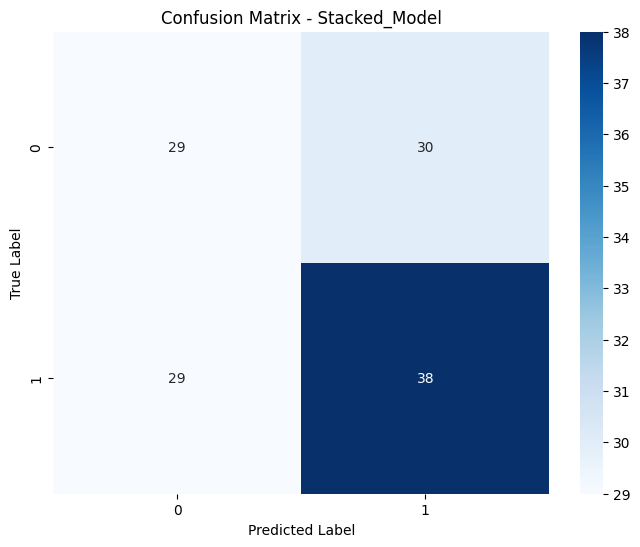

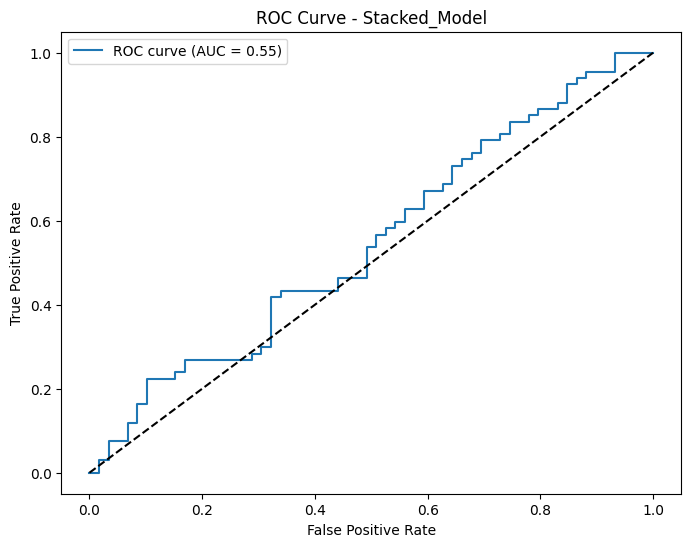


Improved Model Performance:
           Enhanced_RF  Enhanced_XGB  Stacked_Model
Accuracy         0.492         0.492          0.532
Precision        0.522         0.524          0.559
Recall           0.537         0.493          0.567
F1 Score         0.529         0.508          0.563
ROC_AUC          0.548         0.542          0.547


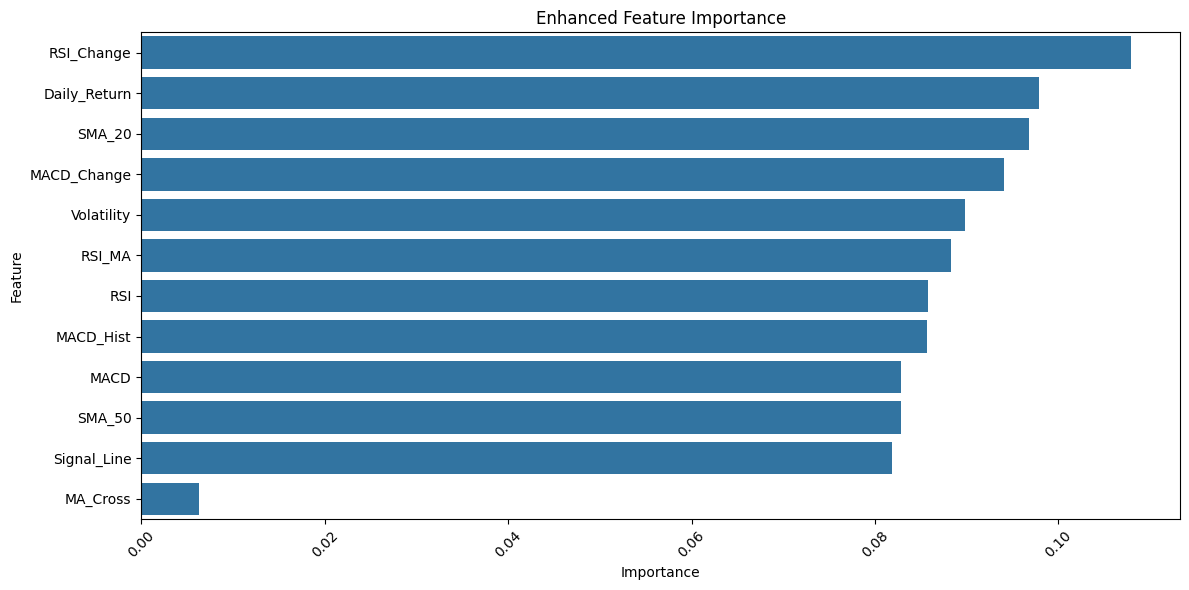


Enhanced Feature Importance:
         Feature  Importance
7     RSI_Change    0.107863
5   Daily_Return    0.097853
0         SMA_20    0.096763
9    MACD_Change    0.094078
6     Volatility    0.089822
8         RSI_MA    0.088241
2            RSI    0.085736
10     MACD_Hist    0.085725
3           MACD    0.082860
1         SMA_50    0.082826
4    Signal_Line    0.081891
11      MA_Cross    0.006341


In [48]:
# Run improved model and get results
improved_results, feature_names = improve_model_advanced(X, y)

# Print results
print("\nImproved Model Performance:")
improved_df = pd.DataFrame(improved_results).round(3)
print(improved_df)

# Modify the feature importance analysis to work with original X and added features
def analyze_best_features(X, y):
    # First recreate the enhanced features
    def add_advanced_features(X):
        X = X.copy()
        X['Volatility'] = X['Daily_Return'].rolling(window=20).std()
        X['RSI_Change'] = X['RSI'].diff()
        X['RSI_MA'] = X['RSI'].rolling(window=10).mean()
        X['MACD_Change'] = X['MACD'].diff()
        X['MACD_Hist'] = X['MACD'] - X['Signal_Line']
        X['MA_Cross'] = (X['SMA_20'] > X['SMA_50']).astype(int)
        return X
    
    # Create enhanced feature set
    X_enhanced = add_advanced_features(X)
    X_enhanced = X_enhanced.dropna()
    y = y[X_enhanced.index]
    
    # Fit Random Forest and get importance
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    rf.fit(X_enhanced, y)
    
    importance = pd.DataFrame({
        'Feature': X_enhanced.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('Enhanced Feature Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return importance

# Run feature importance analysis
feature_importance = analyze_best_features(X, y)
print("\nEnhanced Feature Importance:")
print(feature_importance)

Training LSTM Model...
Epoch 1/50


C:\Users\shant\AppData\Local\Temp\ipykernel_21116\3391064165.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(y[i])
e:\finance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4960 - loss: 0.6922 - val_accuracy: 0.6105 - val_loss: 0.6760
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5667 - loss: 0.6837 - val_accuracy: 0.6105 - val_loss: 0.6690
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5747 - loss: 0.6837 - val_accuracy: 0.6105 - val_loss: 0.6714
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5723 - loss: 0.6851 - val_accuracy: 0.6105 - val_loss: 0.6727
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5879 - loss: 0.6763 - val_accuracy: 0.6105 - val_loss: 0.6726
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5463 - loss: 0.6913 - val_accuracy: 0.6105 - val_loss: 0.6716
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5616 - loss: 0.6817 - val_accuracy: 0.6105 - val_loss: 0.6704
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5784 - loss: 0.6773 - val_accuracy: 0.6105 - val_loss: 0.

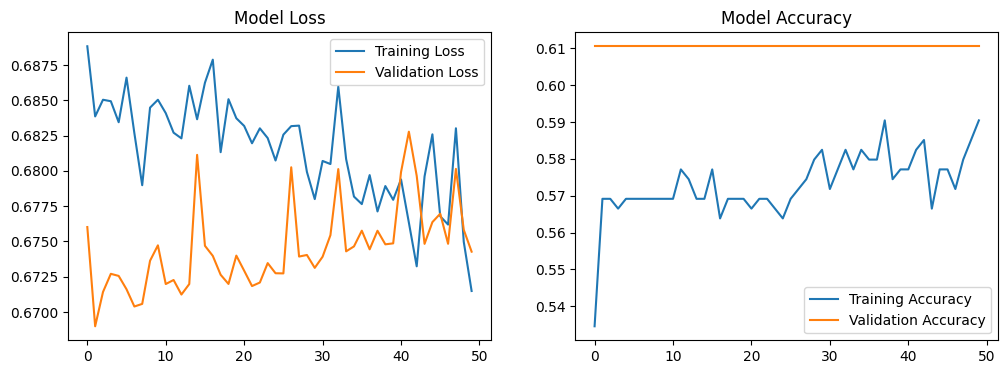


LSTM Results:
   Accuracy  Precision  Recall  F1 Score  ROC_AUC
0     0.415      0.415     1.0     0.587    0.446


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def build_lstm_model(X, y):
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Prepare sequences
    X_seq, y_seq = prepare_sequences(X_scaled, y)
    
    # Split data
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # Build LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate metrics
    results = {
        'Accuracy': accuracy_score(y_test, y_pred_binary),
        'Precision': precision_score(y_test, y_pred_binary),
        'Recall': recall_score(y_test, y_pred_binary),
        'F1 Score': f1_score(y_test, y_pred_binary),
        'ROC_AUC': roc_auc_score(y_test, y_pred)
    }
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()
    
    return model, results, scaler

def prepare_sequences(X, y, lookback=60):
    """
    Prepare sequences for LSTM
    lookback: number of time steps to look back (e.g., 60 days)
    """
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Run the LSTM model
print("Training LSTM Model...")
lstm_model, lstm_results, lstm_scaler = build_lstm_model(X, y)
print("\nLSTM Results:")
print(pd.DataFrame(lstm_results, index=[0]).round(3))

# Plot predictions vs actual
def plot_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('LSTM Predictions vs Actual')
    plt.legend()
    plt.show()

Training Improved LSTM Model...
Epoch 1/100


C:\Users\shant\AppData\Local\Temp\ipykernel_21116\3391064165.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(y[i])
e:\finance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4529 - loss: 0.9785 - val_accuracy: 0.6162 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5406 - loss: 0.7869 - val_accuracy: 0.5758 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5115 - loss: 0.7922 - val_accuracy: 0.3838 - val_loss: 0.7145 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5255 - loss: 0.7914 - val_accuracy: 0.3838 - val_loss: 0.7301 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5214 - loss: 0.7558 - val_accuracy: 0.3838 - val_loss: 0.7540 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5233 - loss: 0.7816 - val_accuracy: 0.3838 - val_loss: 0.7650 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5481 - loss: 0.7293 - val_accuracy

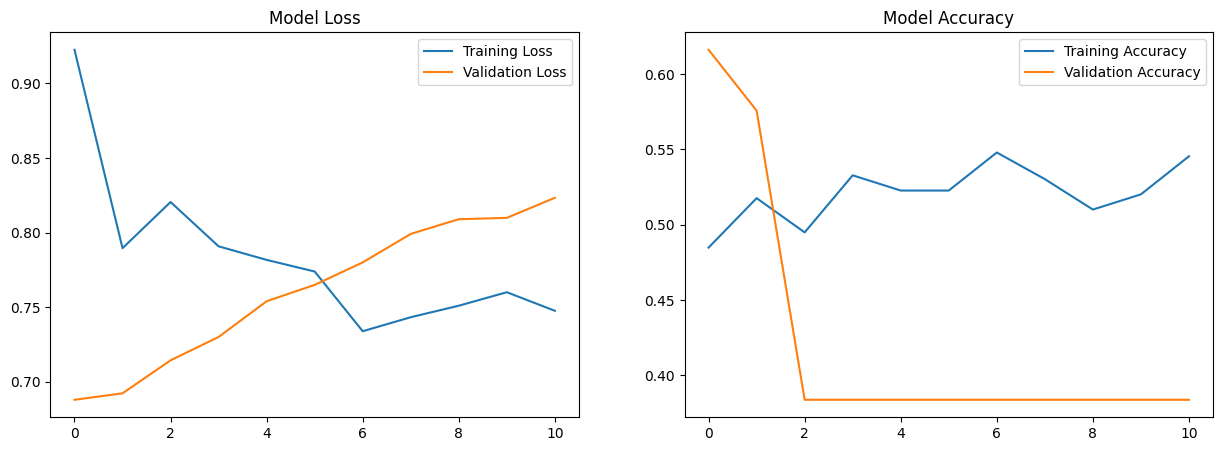


Improved LSTM Results:
   Accuracy  Precision  Recall  F1 Score  ROC_AUC
0     0.411      0.411     1.0     0.583    0.497


In [50]:
def build_improved_lstm_model(X, y):
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Prepare sequences with shorter lookback
    X_seq, y_seq = prepare_sequences(X_scaled, y, lookback=30)  # Reduced from 60
    
    # Split data
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # Build improved LSTM model
    model = Sequential([
        # Bidirectional LSTM layers
        Bidirectional(LSTM(units=64, return_sequences=True, 
                         input_shape=(X_train.shape[1], X_train.shape[2]))),
        BatchNormalization(),
        Dropout(0.3),
        
        Bidirectional(LSTM(units=32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(units=32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(units=16, activation='relu'),
        BatchNormalization(),
        
        Dense(units=1, activation='sigmoid')
    ])
    
    # Compile with different optimizer settings
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Reduce learning rate when plateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
    
    # Train with class weights to handle imbalance
    class_weights = compute_class_weight('balanced', 
                                       classes=np.unique(y_train), 
                                       y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # Evaluate
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    results = {
        'Accuracy': accuracy_score(y_test, y_pred_binary),
        'Precision': precision_score(y_test, y_pred_binary),
        'Recall': recall_score(y_test, y_pred_binary),
        'F1 Score': f1_score(y_test, y_pred_binary),
        'ROC_AUC': roc_auc_score(y_test, y_pred)
    }
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()
    
    return model, results, scaler

# Add necessary imports
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Run improved model
print("Training Improved LSTM Model...")
improved_lstm_model, improved_results, improved_scaler = build_improved_lstm_model(X, y)
print("\nImproved LSTM Results:")
print(pd.DataFrame(improved_results, index=[0]).round(3))

Training Simple LSTM Model...
Available features: ['SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'Daily_Return']

Training data shape: (511, 10, 6)
Test data shape: (128, 10, 6)

Class distribution in training set:
1    0.579256
0    0.420744
Name: proportion, dtype: float64
Epoch 1/50


e:\finance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5548 - loss: 0.7003 - val_accuracy: 0.6117 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5291 - loss: 0.6956 - val_accuracy: 0.5922 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5057 - loss: 0.6957 - val_accuracy: 0.3883 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4320 - loss: 0.6950 - val_accuracy: 0.3883 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4624 - loss: 0.6921 - val_accuracy: 0.3883 - val_loss: 0.6950 - learning_rate: 5.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4921 - loss: 0.6917 - val_accuracy: 0.3883 - val_loss: 0.6952 - learning_rate: 5.0000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


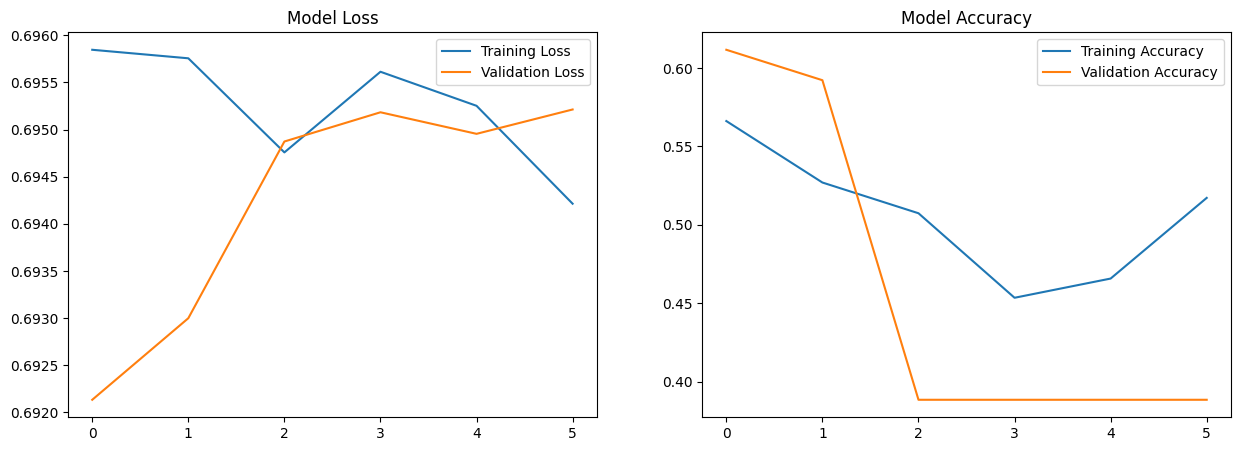


Simple LSTM Results:
   Accuracy  Precision  Recall  F1 Score  ROC_AUC
0      0.43       0.43     1.0     0.601    0.504


In [51]:
def prepare_lstm_data(X, y, test_size=0.2, sequence_length=10):
    """
    Better data preparation with proper scaling
    """
    # First, let's print available features
    print("Available features:", list(X.columns))
    
    # 1. Select features we actually have
    selected_features = [
        'RSI', 'MACD', 'Daily_Return', 'SMA_20', 'SMA_50',
        'Signal_Line'
    ]
    
    X = X[selected_features]
    
    # 2. Scale features individually
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # 3. Create sequences
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X_scaled)):
        X_seq.append(X_scaled.iloc[i-sequence_length:i].values)
        y_seq.append(y.iloc[i])
    
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    # 4. Split maintaining temporal order
    split_idx = int(len(X_seq) * (1 - test_size))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler

def build_simple_lstm(input_shape):
    """
    Simpler but effective LSTM architecture
    """
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        
        LSTM(16, return_sequences=False),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_evaluate_lstm():
    # Prepare data
    X_train, X_test, y_train, y_test, scaler = prepare_lstm_data(X, y, sequence_length=10)
    
    # Print shapes
    print("\nTraining data shape:", X_train.shape)
    print("Test data shape:", X_test.shape)
    
    # Print class distribution
    print("\nClass distribution in training set:")
    print(pd.Series(y_train).value_counts(normalize=True))
    
    # Build model
    model = build_simple_lstm(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
    ]
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', 
                                       classes=np.unique(y_train), 
                                       y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate metrics
    results = {
        'Accuracy': accuracy_score(y_test, y_pred_binary),
        'Precision': precision_score(y_test, y_pred_binary),
        'Recall': recall_score(y_test, y_pred_binary),
        'F1 Score': f1_score(y_test, y_pred_binary),
        'ROC_AUC': roc_auc_score(y_test, y_pred)
    }
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()
    
    return model, results

# Train and evaluate
print("Training Simple LSTM Model...")
simple_lstm_model, simple_results = train_evaluate_lstm()
print("\nSimple LSTM Results:")
print(pd.DataFrame(simple_results, index=[0]).round(3))

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class TimeSeriesTransformer:
    def __init__(self, input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.2):
        self.input_shape = input_shape
        self.head_size = head_size
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_transformer_blocks = num_transformer_blocks
        self.mlp_units = mlp_units
        self.dropout = dropout
        
    def transformer_encoder(self, inputs):
        # Normalization and Attention
        x = LayerNormalization(epsilon=1e-6)(inputs)
        attention_output = MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.head_size, dropout=self.dropout
        )(x, x)
        x = attention_output + inputs

        # Feed Forward
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Conv1D(filters=self.ff_dim, kernel_size=1, activation="relu")(x)
        x = Dropout(self.dropout)(x)
        x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        return x + inputs
    
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = inputs
        
        # Transformer blocks
        for _ in range(self.num_transformer_blocks):
            x = self.transformer_encoder(x)

        # Global average pooling
        x = GlobalAveragePooling1D(data_format="channels_first")(x)
        
        # MLP layers
        for dim in self.mlp_units:
            x = Dense(dim, activation="relu")(x)
            x = Dropout(self.dropout)(x)
        
        # Output layer
        outputs = Dense(1, activation="sigmoid")(x)
        
        return Model(inputs, outputs)



Training Transformer Model...
Training data shape: (503, 20, 6)
Test data shape: (126, 20, 6)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.4941 - loss: 0.7228 - val_accuracy: 0.3861 - val_loss: 0.7263 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4726 - loss: 0.7124 - val_accuracy: 0.3861 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5053 - loss: 0.6990 - val_accuracy: 0.3861 - val_loss: 0.7240 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5468 - loss: 0.6916 - val_accuracy: 0.3861 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4893 - loss: 0.7146 - val_accuracy: 0.3861 - val_loss: 0.7085 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4889 - loss: 0.6980 - val_accuracy: 0.3564 - val_loss: 0.6983 - learning_rate: 0

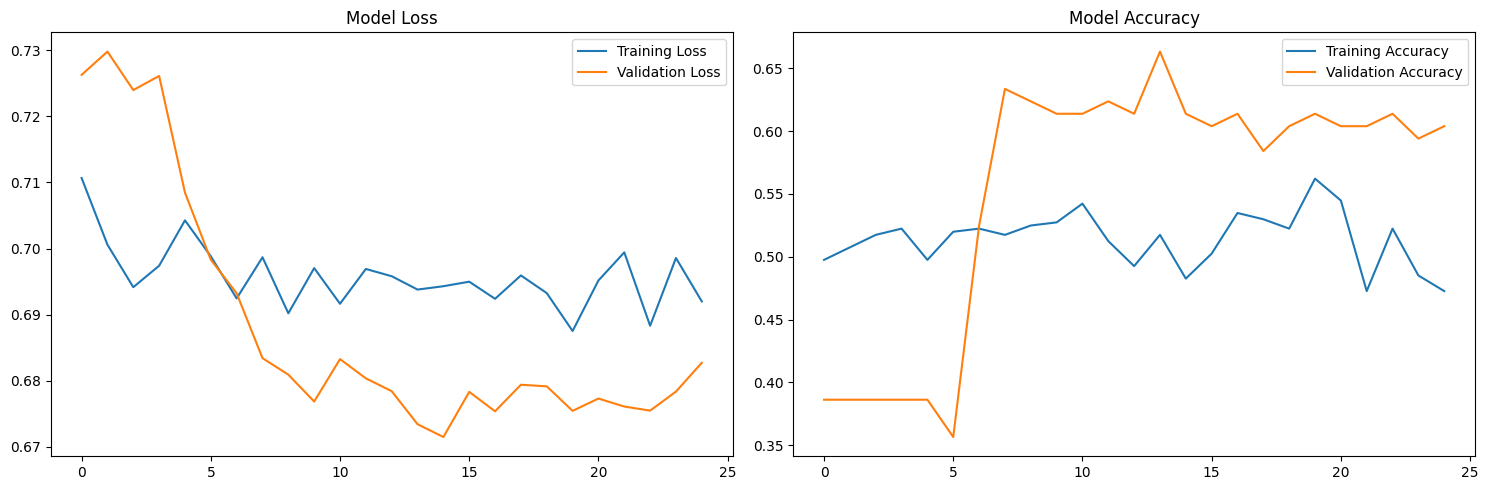

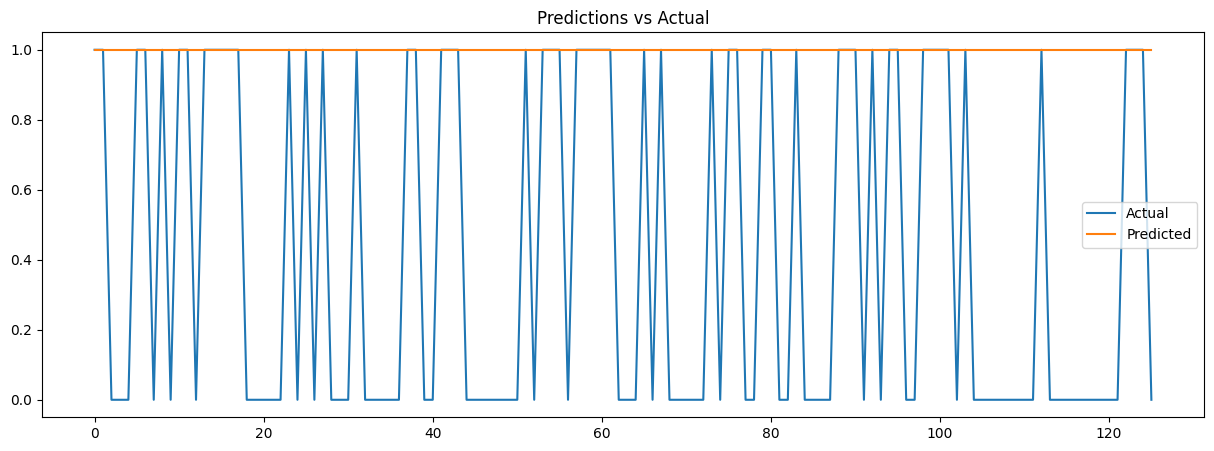


Transformer Model Results:
   Accuracy  Precision  Recall  F1 Score  ROC_AUC
0     0.421      0.421     1.0     0.592    0.581
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Accuracy by Confidence Level:
Bin (0.586, 0.614]: Accuracy = 0.308, Samples = 26
Bin (0.614, 0.619]: Accuracy = 0.320, Samples = 25
Bin (0.619, 0.622]: Accuracy = 0.480, Samples = 25
Bin (0.622, 0.626]: Accuracy = 0.440, Samples = 25
Bin (0.626, 0.632]: Accuracy = 0.560, Samples = 25


C:\Users\shant\AppData\Local\Temp\ipykernel_21116\3555925703.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_name, group in confidence_analysis.groupby('Confidence_Bin'):


In [59]:
def prepare_transformer_data(X, y, sequence_length=20):
    """
    Prepare data for transformer model
    """
    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create sequences
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X_scaled)):
        X_seq.append(X_scaled[i-sequence_length:i])
        y_seq.append(y.iloc[i])
    
    return np.array(X_seq), np.array(y_seq), scaler

def train_transformer_model(X, y):
    # Prepare data
    sequence_length = 20
    X_seq, y_seq, scaler = prepare_transformer_data(X, y, sequence_length)
    
    # Split data
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # Print shapes
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    # Build model
    input_shape = (sequence_length, X.shape[1])
    transformer = TimeSeriesTransformer(
        input_shape=input_shape,
        head_size=128,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[64, 32],
        dropout=0.2
    )
    model = transformer.build_model()
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]
    
    # Class weights for imbalanced data
    class_weights = compute_class_weight('balanced', 
                                       classes=np.unique(y_train), 
                                       y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # Evaluate
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate metrics
    results = {
        'Accuracy': accuracy_score(y_test, y_pred_binary),
        'Precision': precision_score(y_test, y_pred_binary),
        'Recall': recall_score(y_test, y_pred_binary),
        'F1 Score': f1_score(y_test, y_pred_binary),
        'ROC_AUC': roc_auc_score(y_test, y_pred)
    }
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot predictions vs actual
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred_binary, label='Predicted')
    plt.title('Predictions vs Actual')
    plt.legend()
    plt.show()
    
    return model, results, history, X_test, y_test

# Train transformer model
print("Training Transformer Model...")
transformer_model, transformer_results, history, X_test, y_test = train_transformer_model(X, y)  # Unpack all 5 values

# Print results
print("\nTransformer Model Results:")
print(pd.DataFrame(transformer_results, index=[0]).round(3))


# Analyze prediction confidence
def analyze_prediction_confidence(model, X_test, y_test):
    y_pred_proba = model.predict(X_test)
    
    # Create confidence bins
    bins = pd.qcut(y_pred_proba.flatten(), q=5)
    
    # Analyze accuracy by confidence level
    confidence_analysis = pd.DataFrame({
        'Actual': y_test,
        'Predicted_Proba': y_pred_proba.flatten(),
        'Confidence_Bin': bins
    })
    
    print("\nAccuracy by Confidence Level:")
    for bin_name, group in confidence_analysis.groupby('Confidence_Bin'):
        accuracy = accuracy_score(group['Actual'], (group['Predicted_Proba'] > 0.5))
        print(f"Bin {bin_name}: Accuracy = {accuracy:.3f}, Samples = {len(group)}")

# Analyze prediction confidence
# Analyze prediction confidence
analyze_prediction_confidence(transformer_model, X_test, y_test)


In [65]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def build_improved_transformer(X, y):
    # 1. Better data preparation
    def prepare_improved_data(X, y, sequence_length=10):
        # Add technical indicators
        X = X.copy()
        X['MA_Cross'] = (X['SMA_20'] > X['SMA_50']).astype(int)
        X['RSI_Signal'] = (X['RSI'] > 70).astype(int) - (X['RSI'] < 30).astype(int)
        X['MACD_Signal'] = (X['MACD'] > X['Signal_Line']).astype(int)
        
        # Scale features
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Create sequences
        X_seq, y_seq = [], []
        for i in range(sequence_length, len(X_scaled)):
            X_seq.append(X_scaled[i-sequence_length:i])
            y_seq.append(y.iloc[i])
        
        return np.array(X_seq), np.array(y_seq), scaler

    # 2. Prepare data
    sequence_length = 10
    X_seq, y_seq, scaler = prepare_improved_data(X, y, sequence_length)
    
    # Split data
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # 3. Build improved model
    input_shape = (sequence_length, X_seq.shape[2])
    transformer = TimeSeriesTransformer(
        input_shape=input_shape,
        head_size=64,
        num_heads=8,
        ff_dim=32,
        num_transformer_blocks=2,
        mlp_units=[32, 16],
        dropout=0.3
    )
    model = transformer.build_model()
    
    # 4. Compile with different loss and metrics
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC()]
    )
    
    # 5. Training setup
    callbacks = [
        EarlyStopping(
            monitor='val_auc',
            patience=15,
            restore_best_weights=True,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=5,
            min_lr=0.00001
        )
    ]
    
    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    # 6. Train
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # 7. Evaluate
    y_pred_proba = model.predict(X_test)
    
    # Find optimal threshold
    thresholds = np.arange(0.3, 0.7, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Final predictions
    y_pred = (y_pred_proba > best_threshold).astype(int)
    
    results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return model, results, history, X_test, y_test

# Train improved model
print("Training Improved Transformer Model...")
improved_model, improved_results, history, X_test, y_test = build_improved_transformer(X, y)

print("\nImproved Model Results:")
print(pd.DataFrame(improved_results, index=[0]).round(3))

Training Improved Transformer Model...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4972 - auc: 0.4710 - loss: 0.7153 - val_accuracy: 0.4466 - val_auc: 0.4583 - val_loss: 0.6949 - learning_rate: 5.0000e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5259 - auc: 0.5746 - loss: 0.6829 - val_accuracy: 0.4757 - val_auc: 0.4659 - val_loss: 0.6945 - learning_rate: 5.0000e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4838 - auc: 0.4663 - loss: 0.6984 - val_accuracy: 0.4660 - val_auc: 0.4702 - val_loss: 0.6948 - learning_rate: 5.0000e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5492 - auc: 0.5970 - loss: 0.6814 - val_accuracy: 0.4466 - val_auc: 0.4679 - val_loss: 0.6964 - learning_rate: 5.0000e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4598 - auc: 0.4707 - loss: 0.7070 - val_accuracy: 0.4369 - val_auc: 0.4188 - val_loss: 0.6964 - learning_rate: 5.0000e-04
Epoch 6/100
26/26 ━━━

In [66]:
def build_cnn_lstm_model(X, y):
    # Prepare data
    def prepare_data(X, y, sequence_length=10):
        # Add momentum indicators
        X = X.copy()
        X['Price_Momentum'] = X['Close'].pct_change(5)
        X['Volume_Momentum'] = X['Volume'].pct_change(5)
        X['RSI_Momentum'] = X['RSI'].diff(3)
        
        # Scale features
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        # Create sequences
        X_seq, y_seq = [], []
        for i in range(sequence_length, len(X_scaled)):
            X_seq.append(X_scaled.iloc[i-sequence_length:i].values)
            y_seq.append(y.iloc[i])
        
        return np.array(X_seq), np.array(y_seq), scaler
    
    # Prepare data
    sequence_length = 10
    X_seq, y_seq, scaler = prepare_data(X, y, sequence_length)
    
    # Split data
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # Build CNN-LSTM model
    model = Sequential([
        # CNN layers
        Conv1D(filters=32, kernel_size=3, padding='same', input_shape=(sequence_length, X_seq.shape[2])),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(pool_size=2),
        
        # LSTM layers
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(30),
        Dropout(0.2),
        
        # Dense layers
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001)
    ]
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        class_weight={0: 1, 1: 1},  # Adjust if needed
        verbose=1
    )
    
    # Evaluate
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    results = {
        'Accuracy': accuracy_score(y_test, y_pred_binary),
        'Precision': precision_score(y_test, y_pred_binary),
        'Recall': recall_score(y_test, y_pred_binary),
        'F1 Score': f1_score(y_test, y_pred_binary),
        'ROC_AUC': roc_auc_score(y_test, y_pred)
    }
    
    return model, results, history, X_test, y_test

# Train CNN-LSTM model
print("Training CNN-LSTM Model...")
cnn_lstm_model, cnn_lstm_results, history, X_test, y_test = build_cnn_lstm_model(X, y)

print("\nCNN-LSTM Model Results:")
print(pd.DataFrame(cnn_lstm_results, index=[0]).round(3))

Training CNN-LSTM Model...


KeyError: 'Close'